In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import exp, abs, log
from scipy.special import gamma, factorial
import os
import scipy.stats as stats

In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
from scipy.special import digamma, polygamma 

def df(b, xs):
    n = len(xs)
    mu = np.mean(xs)
    g = 1
    g += digamma(1/b)/b
    tmp1 = tmp2 = tmp3 = 0
    for xi in xs:
        tmp1 += abs(xi-mu)**b * log(abs(xi-mu))
        tmp2 += abs(xi-mu)**b
        tmp3 += abs(xi-mu)**b * log(abs(xi-mu))**2
    g -= tmp1/tmp2
    g += log(b / n * tmp2) / b
    
    gg = -digamma(1/b)/b**2 - polygamma(1, 1/b)/b**3 + 1/b**2
    gg -= tmp3/tmp2
    gg += (tmp1/tmp2)**2
    gg += tmp1/(tmp2*b)
    gg -= log(b / n * tmp2) / b**2
    return (g, gg)

def est_b(xs, max_iter=1000, ep=1e-7):
    n = len(xs)
    m1 = np.mean([abs(xi) for xi in xs])
    m2 = np.mean([xi**2 for xi in xs])
    b = m1/np.sqrt(m2)
#     b = 2
    
    for _ in range(max_iter):
        g, gg = df(b, xs)
        b = b - g/gg
        print(b)
        if abs(g/(b*gg))<ep:
            break
    return b

def est_a(xs, b):
    mu = np.mean(xs)
    n = len(xs)
    res = 0
    for xi in xs:
        res += abs(xi-mu)**b
    res = (b / n * res)**(1/b)
    return 0.5*res

def est(xs):
    mu = np.mean(xs)
    b = est_b(xs)
    a = est_a(xs, b)
    return (mu, a, b)

In [4]:
def ggd(x, p=2.0, mu=0.0, alpha=1.0):
    cp = p / ( 2**((p+1)/p) * gamma(1/p) )
    res = cp/alpha*exp(-abs(x-mu)**p/(2*alpha**p))
    return res

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


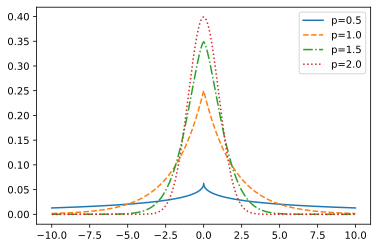

In [5]:
x = np.arange(-10,10,0.01)
stys = ['-', '--', '-.', ':']

plt.figure()
for i,p in enumerate([0.5, 1.0, 1.5, 2]):
    plt.plot(x,ggd(x,p),stys[i],label='p=%.1f'%p)
plt.legend()
plt.savefig('./figs/ggdpdf.eps')

In [6]:
lb = 10
maxiter = 1000
subn = 100

In [7]:
def get_res():
    data_path1 = './tmp2/snp500-12_phase00_iter5000_subn100_lb5_M20_matcnt30_invTrue_ggdTrue.npz'
    data1 = np.load(data_path1)
    return data1['predY0'], data1['std_varY0'], data1['sample_Y0']

In [8]:
predY0, std_varY0, sample_Y0 = get_res()
err = (predY0 - sample_Y0).reshape(-1)
raw = sample_Y0.reshape(-1)

# Estimate raw price

In [9]:
raw

array([ 0.00210305, -0.0021863 ,  0.00033824, ...,  0.00110087,
       -0.00374979,  0.00429739])

In [10]:
len(err)

10000

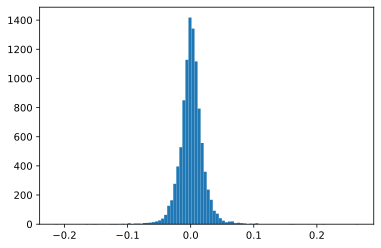

In [11]:
plt.figure()
counts, bins = np.histogram(raw,bins=100)
plt.hist(bins[:-1], bins, weights=counts);

In [12]:
mu = np.mean(raw)
sig = np.std(raw)
xrg = np.arange(-0.15, 0.15, 0.001)

In [13]:
print(np.mean(raw), np.std(raw))

0.0010671841429959995 0.019291223124031764


In [14]:
(mu, a, b) = est(raw)

1.0112510582476832
1.036730154227439
1.0368096874492196
1.036809688173582


In [15]:
print(mu, a, b)

0.0010671841429959995 0.007017787755407226 1.036809688173582


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


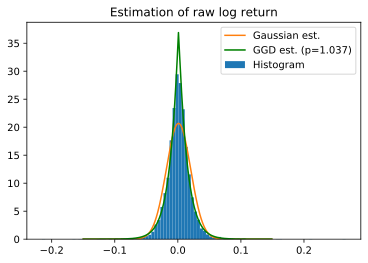

In [16]:
cc=(bins[1]-bins[0])*len(raw)
plt.figure()
plt.hist(bins[:-1], bins, weights=counts/cc, label='Histogram');
plt.plot(xrg, stats.norm.pdf(xrg, mu, sig), label='Gaussian est.')
# plt.plot(xrg, y, 'r-', label='kern est. PDF')
plt.plot(xrg, ggd(xrg, b, mu, a), 'g-', label='GGD est. (p=%.3f)'%b)
plt.title('Estimation of raw log return')
plt.legend()
plt.savefig('./figs/est_rt.eps')

In [17]:
ggd2lik=0
for xi in err:
    tmp = stats.norm.pdf(xi, mu, sig)
    if tmp > 0:
        ggd2lik += log(tmp)

In [18]:
ggd2lik

25193.45169681211

In [19]:
ggdplik=0
for xi in err:
    tmp = ggd(xi, b, mu, a)
    if tmp > 0:
        ggdplik += log(tmp)

In [20]:
ggdplik

26105.048662630168

# Estimate error

In [21]:
err

array([-0.00030046,  0.00277229,  0.00131938, ..., -0.00090225,
        0.00484827, -0.00111189])

In [22]:
len(err)

10000

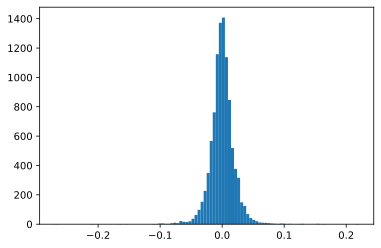

In [23]:
plt.figure()
counts, bins = np.histogram(err,bins=100)
plt.hist(bins[:-1], bins, weights=counts);

In [24]:
mu = np.mean(err)
sig = np.std(err)

In [25]:
xrg = np.arange(-0.15, 0.15, 0.001)

In [26]:
print(np.mean(err), np.std(err))

-4.632351377470214e-05 0.019447916135540203


In [27]:
(mu, a, b) = est(err)

1.0151441106135457
1.0401759586910186
1.0402493546848175
1.0402493552758696


In [28]:
print(mu, a, b)

-4.632351377470214e-05 0.007109454120285581 1.0402493552758696


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


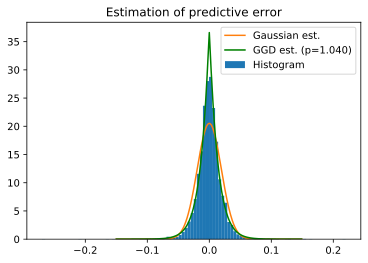

In [29]:
cc=(bins[1]-bins[0])*len(err)
plt.figure()
plt.hist(bins[:-1], bins, weights=counts/cc, label='Histogram');
plt.plot(xrg, stats.norm.pdf(xrg, mu, sig), label='Gaussian est.')
# plt.plot(xrg, y, 'r-', label='kern est. PDF')
plt.plot(xrg, ggd(xrg, b, mu, a), 'g-', label='GGD est. (p=%.3f)'%b)
plt.title('Estimation of predictive error')
plt.legend()
plt.savefig('./figs/est_err.eps')

In [30]:
ggd2lik=0
for xi in err:
    tmp = stats.norm.pdf(xi, mu, sig)
    if tmp > 0:
        ggd2lik += log(tmp)

In [31]:
ggd2lik

25210.76821013781

In [32]:
ggdplik=0
for xi in err:
    tmp = ggd(xi, b, mu, a)
    if tmp > 0:
        ggdplik += log(tmp)

In [33]:
ggdplik

26142.21542040185